# Vector Search with SAM3 + DINOv3

This notebook implements a vector search pipeline using SAM3 for clothing segmentation and DINOv3 for embedding generation.

In [1]:
import torch
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Revert to using sam3 package as transformers support is not ready
from sam3.model_builder import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor
from transformers import AutoImageProcessor, AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Initialize SAM3
# Fix: Explicitly provide bpe_path to avoid FileNotFoundError in sam3 package
bpe_path = os.path.join("assets", "bpe_simple_vocab_16e6.txt.gz")

if not os.path.exists(bpe_path):
    # Fallback to absolute path if running from a different directory
    # Adjust this path if necessary
    bpe_path = os.path.join(os.getcwd(), "sam3", "assets", "bpe_simple_vocab_16e6.txt.gz")

if not os.path.exists(bpe_path):
     print(f"Warning: BPE path {bpe_path} not found. Please ensure the assets directory exists.")

print(f"Using BPE path: {bpe_path}")

sam3_model = build_sam3_image_model(bpe_path=bpe_path).to(device)
sam3_processor = Sam3Processor(sam3_model, confidence_threshold=0.3)

# Initialize DINOv3
dino_id = "facebook/dinov3-vitl16-pretrain-lvd1689m"
dino_processor = AutoImageProcessor.from_pretrained(dino_id)
dino_model = AutoModel.from_pretrained(dino_id).to(device)
dino_model.eval()

Using BPE path: assets/bpe_simple_vocab_16e6.txt.gz


DINOv3ViTModel(
  (embeddings): DINOv3ViTEmbeddings(
    (patch_embeddings): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (rope_embeddings): DINOv3ViTRopePositionEmbedding()
  (layer): ModuleList(
    (0-23): 24 x DINOv3ViTLayer(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attention): DINOv3ViTAttention(
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (o_proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (layer_scale1): DINOv3ViTLayerScale()
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): DINOv3ViTMLP(
        (up_proj): Linear(in_features=1024, out_features=4096, bias=True)
        (down_proj): Linear(in_features=4096, out_features=1024, bias=True)
        (act_fn): GELUA

In [3]:
def l2_normalize(x: torch.Tensor) -> torch.Tensor:
    return x / (x.norm(dim=-1, keepdim=True) + 1e-12)

def segment_clothes(image: Image.Image, prompt: str = "clothing"):
    # SAM3 processor usage in sam3 package is different from transformers
    inference_state = sam3_processor.set_image(image)
    out = sam3_processor.set_text_prompt(state=inference_state, prompt=prompt)
    
    masks = out["masks"]
    scores = out["scores"]

    if masks is None or len(masks) == 0:
        return None

    masks = masks.to(device)
    scores = scores.to(device)

    # Filter by score
    keep = scores > 0.3
    if keep.any():
        sel_masks = masks[keep]
    else:
        idx = torch.argmax(scores)
        sel_masks = masks[idx : idx + 1]

    # Merge masks
    merged = sel_masks.any(dim=0).float()
    merged = merged.cpu().numpy()
    
    if merged.ndim == 3 and merged.shape[0] == 1:
        merged = merged.squeeze(0)
        
    return merged

def crop_by_mask(image: Image.Image, mask: np.ndarray, pad: int = 4):
    y_indices, x_indices = np.where(mask > 0.5)
    if len(x_indices) == 0 or len(y_indices) == 0:
        return None

    x1, x2 = x_indices.min(), x_indices.max()
    y1, y2 = y_indices.min(), y_indices.max()

    x1 = max(x1 - pad, 0)
    y1 = max(y1 - pad, 0)
    x2 = min(x2 + pad, image.width - 1)
    y2 = min(y2 + pad, image.height - 1)

    return image.crop((x1, y1, x2 + 1, y2 + 1))

def clothes_embedding(image_path: str, prompt: str = "clothing") -> torch.Tensor:
    try:
        image = Image.open(image_path).convert("RGB")
        mask = segment_clothes(image, prompt=prompt)
        
        if mask is None:
            return None

        crop = crop_by_mask(image, mask)
        
        if crop is None:
            return None

        inputs = dino_processor(images=crop, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = dino_model(**inputs)
            cls = outputs.last_hidden_state[:, 0]
            emb = l2_normalize(cls)

        return emb.cpu()  # shape: [1, D]
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [4]:
# Batch Indexing with DataLoader
from torch.utils.data import DataLoader
# Import from the separate file to allow multiprocessing in Jupyter
import sys
import os

# Add current directory to sys.path so we can import dataset_utils
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

try:
    from sam3.dataset_utils import ImageDataset, collate_fn
except ImportError:
    # Fallback if running from sam3 directory directly
    from dataset_utils import ImageDataset, collate_fn

def process_batch(images, paths, prompt="clothing"):
    if not images:
        return []
        
    # 1. SAM3 Inference (Batch)
    # Note: sam3_processor might handle batching differently depending on version,
    # but generally it accepts a list of images.
    try:
        # Prepare inputs for SAM3
        # We process one by one for SAM3 if batching is tricky with the current processor wrapper,
        # but let's try to use the processor's batch capability if available.
        # Given the custom Sam3Processor in the local package, let's check if it supports batch.
        # If not, we loop. To be safe and robust given the previous issues, let's loop SAM3 but batch DINO.
        # Actually, let's try to be efficient. 
        
        crops = []
        valid_indices = []
        
        for i, image in enumerate(images):
            try:
                mask = segment_clothes(image, prompt=prompt)
                if mask is not None:
                    crop = crop_by_mask(image, mask)
                    if crop is not None:
                        crops.append(crop)
                        valid_indices.append(i)
            except Exception as e:
                print(f"Error segmenting {paths[i]}: {e}")
                continue

        if not crops:
            return []

        # 2. DINO Inference (Batch)
        inputs = dino_processor(images=crops, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = dino_model(**inputs)
            # Use CLS token (index 0)
            cls_tokens = outputs.last_hidden_state[:, 0]
            embeddings = l2_normalize(cls_tokens).cpu()

        results = []
        for idx, emb in zip(valid_indices, embeddings):
            results.append({
                "path": paths[idx],
                "embedding": emb
            })
            
        return results
        
    except Exception as e:
        print(f"Batch processing error: {e}")
        return []

# Indexing
image_dir = "../data/images_original"
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Setup DataLoader
batch_size = 64  # Adjust based on VRAM
dataset = ImageDataset(image_files)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

vector_store = []

print(f"Indexing {len(image_files)} images with batch size {batch_size}...")
for images, paths in tqdm(dataloader):
    batch_results = process_batch(images, paths)
    vector_store.extend(batch_results)

print(f"Indexed {len(vector_store)} images.")

Indexing 5762 images with batch size 64...


  0%|          | 0/91 [00:00<?, ?it/s]

Unused or unrecognized kwargs: padding.
100%|██████████| 91/91 [33:27<00:00, 22.07s/it]

Indexed 5110 images.


In [5]:
import pickle

save_path = "crop_sam3_dino.pkl"

with open(save_path, "wb") as f:
    pickle.dump(vector_store, f)

print(f"Saved {len(vector_store)} vectors to {save_path}")

Saved 5110 vectors to crop_sam3_dino.pkl


In [12]:
import pickle

with open("crop_sam3_dino.pkl", "rb") as f:
    vector_stores = pickle.load(f)

print("Loaded items:", len(vector_stores))

Loaded items: 5110


In [10]:
# Search Function
def search_similar(query_image_path: str, top_k: int = 5):
    print(f"Processing query image: {query_image_path}")
    query_emb = clothes_embedding(query_image_path)
    if query_emb is None:
        print("Could not process query image.")
        return

    scores = []
    for item in vector_store:
        # Cosine similarity
        sim = torch.nn.functional.cosine_similarity(query_emb, item["embedding"])
        scores.append((sim.item(), item["path"]))
    
    scores.sort(key=lambda x: x[0], reverse=True)
    
    # Visualize
    fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 5))
    
    # Query
    axes[0].imshow(Image.open(query_image_path))
    axes[0].set_title("Query")
    axes[0].axis("off")
    
    for i in range(top_k):
        if i < len(scores):
            score, path = scores[i]
            try:
                axes[i+1].imshow(Image.open(path))
                axes[i+1].set_title(f"Score: {score:.3f}")
                axes[i+1].axis("off")
            except Exception as e:
                print(f"Error loading result image {path}: {e}")
            
    plt.show()

Processing query image: ../data/images_original/ff795dc2-36b1-4122-bf4a-6e2916a90182.jpg


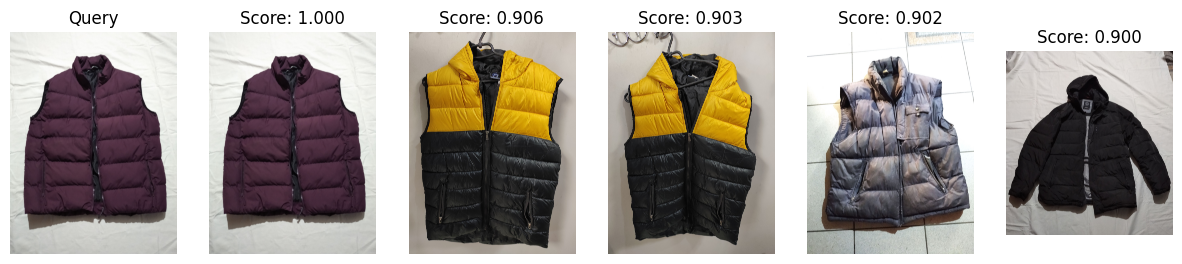

In [11]:
# Example Search
# Replace with a valid image path from your sample set or a new image
query_image = "../data/images_original/ff795dc2-36b1-4122-bf4a-6e2916a90182.jpg"
if os.path.exists(query_image):
    search_similar(query_image)
else:
    print(f"Query image not found: {query_image}")